In [3]:
# load all required libraries for Dog's Breed Identification Project
import cv2
import numpy as np 
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.utils.multiclass import unique_labels

In [10]:
#read the csv file
df_labels = pd.read_csv("D:\\Dog Breed Classification\\Data Set\\labels.csv")
#store training and testing images folder location
train_file = "D:\\Dog Breed Classification\\Data Set\\train\\"
test_file = "D:\\Dog Breed Classification\\Data Set\\test\\"

In [11]:
print(df_labels)

                                     id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]


In [12]:
    print("Total number of unique Dog Breeds :",len(df_labels.breed.unique()))

Total number of unique Dog Breeds : 120


In [13]:
#specify number
num_breeds = 120
im_size = 224
batch_size = 64
encoder = LabelEncoder()

In [14]:
#get all 120 unique breeds record 
breed_dict = list(df_labels['breed'].value_counts().keys()) 
new_list = sorted(breed_dict,reverse=True)[:num_breeds+1:1]
#change the dataset to have those 120 unique breed records
df_labels = df_labels.query('breed in @new_list')

In [15]:
#create new column which will contain image name with the image extension
df_labels['img_file'] = df_labels['id'].apply(lambda x: x + ".jpg")
print(df_labels['img_file'])

0        000bec180eb18c7604dcecc8fe0dba07.jpg
1        001513dfcb2ffafc82cccf4d8bbaba97.jpg
2        001cdf01b096e06d78e9e5112d419397.jpg
3        00214f311d5d2247d5dfe4fe24b2303d.jpg
4        0021f9ceb3235effd7fcde7f7538ed62.jpg
                         ...                 
10217    ffd25009d635cfd16e793503ac5edef0.jpg
10218    ffd3f636f7f379c51ba3648a9ff8254f.jpg
10219    ffe2ca6c940cddfee68fa3cc6c63213f.jpg
10220    ffe5f6d8e2bff356e9482a80a6e29aac.jpg
10221    fff43b07992508bc822f33d8ffd902ae.jpg
Name: img_file, Length: 10222, dtype: object


In [9]:
#create a numpy array of the shape
#(number of dataset records, image size , image size, 3 for rgb channel ayer)
#this will be input for model
train_x = np.zeros((len(df_labels), im_size, im_size, 3), dtype='float32')
 
#iterate over img_file column of our dataset
for i, img_id in enumerate(df_labels['img_file']):
  #read the image file and convert into numeric format
  #resize all images to one dimension i.e. 224x224
  #we will get array with the shape of
  # (224,224,3) where 3 is the RGB channels layers
  img = cv2.resize(cv2.imread(train_file+img_id,cv2.IMREAD_COLOR),((im_size,im_size)))
  #scale array into the range of -1 to 1.
  #preprocess the array and expand its dimension on the axis 0 
  img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
  #update the train_x variable with new element
  train_x[i] = img_array
  

In [10]:
#This will be the target for the model.
#convert breed names into numerical format
train_y = encoder.fit_transform(df_labels["breed"].values)
train_y

array([19, 37, 85, ...,  3, 75, 28])

In [11]:
#split the dataset in the ratio of 80:20. 
#80% for training and 20% for testing purpose
x_train, x_test, y_train, y_test = train_test_split(train_x,train_y,test_size=0.2,random_state=42)

In [12]:
x_train

array([[[[ 0.4901961 ,  0.49803925,  0.5137255 ],
         [ 0.654902  ,  0.6627451 ,  0.6784314 ],
         [ 0.81960785,  0.827451  ,  0.84313726],
         ...,
         [-0.5294118 , -0.23137254,  0.13725495],
         [-0.5686275 , -0.24705881,  0.11372554],
         [-0.54509807, -0.2235294 ,  0.13725495]],

        [[ 0.28627455,  0.2941177 ,  0.30980396],
         [ 0.8901961 ,  0.8980392 ,  0.9137255 ],
         [ 0.9607843 ,  0.96862745,  0.96862745],
         ...,
         [-0.5058824 , -0.20784312,  0.16078436],
         [-0.5372549 , -0.21568626,  0.14509809],
         [-0.52156866, -0.19999999,  0.16078436]],

        [[ 0.5529412 ,  0.56078434,  0.5764706 ],
         [ 0.7490196 ,  0.75686276,  0.77254903],
         [ 0.7254902 ,  0.73333335,  0.7490196 ],
         ...,
         [-0.54509807, -0.26274508,  0.11372554],
         [-0.5764706 , -0.25490195,  0.10588241],
         [-0.56078434, -0.23921567,  0.12156868]],

        ...,

        [[ 0.3176471 ,  0.35686278,  0

In [13]:
#Image augmentation using ImageDataGenerator class
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
 
#generate images for training sets 
train_generator = train_datagen.flow(x_train, 
                                     y_train, 
                                     batch_size=batch_size)
 
#same process for Testing sets also by declaring the instance
test_datagen = ImageDataGenerator()
 
test_generator = test_datagen.flow(x_test, 
                                     y_test, 
                                     batch_size=batch_size)

In [4]:
#building the model using MobileNetV2 with input shape of our image array
#weights for our network will be from of imagenet dataset
#we will not include the first Dense layer
model =  MobileNetV2(weights='imagenet', include_top=False)

#falttening output & adding Fully-Connected Layers
x= model.output
x= BatchNormalization()(x)
x= GlobalAveragePooling2D()(x)
x= Dropout(0.5)(x)




In [5]:
#add output layer having the shape equal to number of breeds
preds = Dense(num_breeds, activation='softmax')(x)
 
#create model class with inputs and outputs
model = Model(inputs=model.input, outputs=preds)

model.summary()

NameError: name 'num_breeds' is not defined

In [17]:
for layers in model.layers[:-4]:
    layers.trainable = False
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                           

In [39]:
#epochs for model training and learning rate for optimizer
epochs = 20
learning_rate = 1e-3
   
#using RMSprop optimizer to compile or build the model
optimizer = RMSprop(learning_rate=learning_rate,rho=0.9)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])
 
#fit the training generator data and train the model
hist = model.fit(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= epochs,
                 validation_data= test_generator,
                 validation_steps= x_test.shape[0] // batch_size)
 
#Save the model for prediction
model.save("model")

Epoch 1/20
127/127 [==============================] - 819s 6s/step - loss: 2.1509 - accuracy: 0.4759 - val_loss: 0.7481 - val_accuracy: 0.7631
Epoch 2/20
127/127 [==============================] - 577s 5s/step - loss: 1.1738 - accuracy: 0.6628 - val_loss: 0.7257 - val_accuracy: 0.7676
Epoch 3/20
127/127 [==============================] - 616s 5s/step - loss: 1.0067 - accuracy: 0.6959 - val_loss: 0.7180 - val_accuracy: 0.7883
Epoch 4/20
127/127 [==============================] - 571s 5s/step - loss: 0.9144 - accuracy: 0.7297 - val_loss: 0.6984 - val_accuracy: 0.7853
Epoch 5/20
127/127 [==============================] - 616s 5s/step - loss: 0.8228 - accuracy: 0.7508 - val_loss: 0.7537 - val_accuracy: 0.7742
Epoch 6/20
127/127 [==============================] - 535s 4s/step - loss: 0.7664 - accuracy: 0.7690 - val_loss: 0.7100 - val_accuracy: 0.7923
Epoch 7/20
127/127 [==============================] - 540s 4s/step - loss: 0.7499 - accuracy: 0.7675 - val_loss: 0.7285 - val_accuracy: 0.7903

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [18]:
model.evaluate(x_test, y_test)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


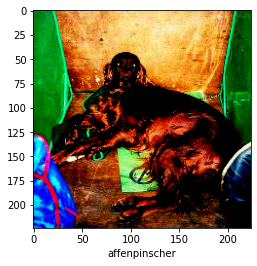

In [19]:
def plot_sample(x, y, index):
    plt.figure(figsize = (30,4))
    plt.imshow(x[index])
    plt.xlabel(df_labels['breed'][y[index]])
    
plot_sample(x_test, y_test, 1)

In [53]:
y_pred = model.predict(x_test)
y_pred

64/64 [==============================] - 57s 874ms/step


array([[2.05049067e-09, 2.53206120e-13, 4.87724916e-10, ...,
        1.73908066e-09, 1.07793126e-08, 1.61645974e-09],
       [4.05876790e-08, 7.57869543e-07, 6.60409682e-08, ...,
        2.58612684e-12, 1.65696094e-14, 2.51128842e-08],
       [3.19722648e-09, 1.24193666e-05, 1.70746806e-10, ...,
        2.63921285e-09, 5.10301523e-10, 2.20495999e-09],
       ...,
       [1.79967621e-11, 3.60113495e-10, 1.21072596e-10, ...,
        1.06440247e-13, 8.42945234e-14, 4.48130005e-10],
       [1.14308597e-11, 2.02586309e-10, 9.38886208e-12, ...,
        1.07161252e-10, 1.63358761e-13, 4.15684639e-11],
       [7.53879537e-09, 4.07739975e-09, 1.92056104e-09, ...,
        2.96309421e-09, 1.52128241e-11, 1.78845539e-07]], dtype=float32)

In [54]:
y_result = [np.argmax(element) for element in y_pred]
y_result

[111,
 56,
 97,
 40,
 52,
 47,
 103,
 115,
 19,
 29,
 58,
 112,
 62,
 16,
 31,
 1,
 6,
 35,
 40,
 28,
 10,
 86,
 7,
 57,
 84,
 61,
 102,
 19,
 19,
 56,
 1,
 11,
 91,
 35,
 82,
 14,
 56,
 30,
 95,
 117,
 62,
 103,
 11,
 63,
 36,
 26,
 60,
 10,
 26,
 54,
 90,
 41,
 114,
 51,
 35,
 50,
 54,
 13,
 84,
 34,
 84,
 84,
 28,
 94,
 17,
 69,
 74,
 93,
 2,
 27,
 63,
 16,
 112,
 103,
 118,
 10,
 30,
 26,
 30,
 23,
 68,
 53,
 60,
 69,
 1,
 55,
 21,
 32,
 107,
 84,
 60,
 83,
 114,
 63,
 63,
 43,
 85,
 38,
 18,
 72,
 14,
 52,
 65,
 6,
 34,
 39,
 31,
 1,
 31,
 52,
 6,
 8,
 110,
 119,
 87,
 0,
 92,
 65,
 97,
 100,
 48,
 13,
 105,
 67,
 63,
 9,
 86,
 79,
 110,
 12,
 16,
 16,
 17,
 93,
 4,
 61,
 104,
 85,
 71,
 92,
 86,
 105,
 3,
 104,
 24,
 71,
 72,
 42,
 52,
 94,
 109,
 81,
 101,
 62,
 117,
 73,
 80,
 116,
 2,
 115,
 46,
 106,
 46,
 68,
 36,
 84,
 115,
 100,
 19,
 22,
 70,
 9,
 98,
 15,
 118,
 26,
 39,
 55,
 78,
 22,
 51,
 67,
 114,
 43,
 16,
 26,
 28,
 3,
 108,
 29,
 63,
 43,
 4,
 97,
 81,
 29,
 65,
 

In [55]:
y_test

array([111,  56,  97, ...,  56,  49,  67])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


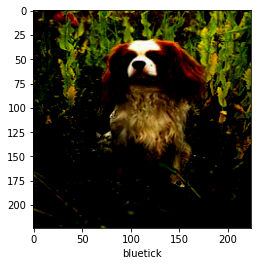

In [20]:
plot_sample(x_test, y_test, 57)

In [21]:
df_labels['breed'][y_result[57]]

NameError: name 'y_result' is not defined

In [69]:
print("Classsification Report : \n\n", classification_report(y_test, y_result))

Classsification Report : 

               precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.96      1.00      0.98        22
           2       1.00      0.92      0.96        26
           3       0.91      0.78      0.84        27
           4       0.64      0.58      0.61        12
           5       0.71      0.79      0.75        19
           6       0.67      0.62      0.64        26
           7       0.86      0.90      0.88        20
           8       0.91      0.67      0.77        15
           9       0.70      0.84      0.76        19
          10       1.00      0.86      0.93        29
          11       0.92      0.92      0.92        26
          12       0.91      0.71      0.80        14
          13       0.91      0.81      0.86        26
          14       0.78      1.00      0.88        21
          15       0.60      0.88      0.71        17
          16       0.75      1.00      0.86        12

In [85]:
def plot(x,y):
    labels = unique_labels(y_test)
    column = [f'Predicted{label}' for label in labels]
    indices = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(x,y), columns = column, index = indices)
    
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

<AxesSubplot:>

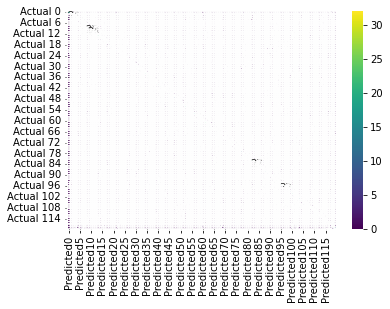

In [88]:
plot(y_test, y_result)

1/1 [==============================] - 1s 648ms/step


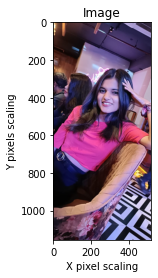

Predicted Breed for this Dog is : scottish_deerhound


In [16]:
#load the model
model = load_model("model")
 
#get the image of the dog for prediction
pred_img_path = "C:\\Users\\asus\\Dropbox\\My PC (LAPTOP-KVI3FLV1)\\Downloads\\Sonu.jpg"
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
 
#feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))
 
#display the image of dog
#im= Image.open(pred_img_path)
#im.show()

plt.title("Image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
 
image = mpimg.imread(pred_img_path)
plt.imshow(image)
plt.show()

#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)